In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import ipywidgets as widgets
import warnings
import pandas as pd
import itertools

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

In [2]:
# Source: https://www.kaggle.com/code/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Introduction
For this project, we decided to work on an image classification problem using neural networks to solve multi-label classification. Initially, we began by researching different datasets and deciding on a dataset which was generic (not affiliated with any existing IPs) and contained multi-labels. The dataset we choose to work on was one of generic video game sprites. This was pertinent to us --especially in the current day and age-- because the topic of AI generated art is becoming increasingly at the forefront of AI discussions within contemporary society. While no generative models were created here, we have decided to work on image classification nonetheless

## The Data
As previously mentioned, we chose to work on creating a model to classify low-resolution game sprites. For this, we went with the [Pixel Art dataset by Ebrahim Elgazar](https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art). This provides us with a set of 595 sprites to look at.

*For some reason, the original dataset is actually 89,000 images of the same 894 sprites. But, indices from 244 to 543 are downscaled images, so we didn't want to work on those. That leaves use with 595 sprites to work on*

In [3]:
data = np.load('./Dataset1/sprites_labels.npy')
sprites = np.load('./Dataset1/sprites.npy')

y = data[:894]
y = np.delete(y, slice(244, 543), axis=0)
print(y.shape)

X = sprites[:894]
X = np.delete(X, slice(244, 543), axis=0)
print(X.shape)

unique, counts = np.unique(y, return_counts=True, axis=0)
for i in range(len(unique)):
    print(unique[i], counts[i])

(595, 5)
(595, 16, 16, 3)
[0. 0. 0. 0. 1.] 80
[0. 0. 0. 1. 0.] 350
[0. 0. 1. 0. 0.] 60
[0. 1. 0. 0. 0.] 25
[1. 0. 0. 0. 0.] 80


The labels for said data are as follows:
[Character (Front), Monster, Food, Item, Character (Side)]
- Characters (0-159)
    - [1, 0, 0, 0 ,0] - Front Facing
    - [0, 0, 0, 0, 1] - Side Facing
- Monsters (160-183)
    - [0, 1, 0, 0, 0]
- Food (184-243)
    - [0, 0, 1, 0, 0]
- Downscaled Monsters - RED (244-343) *excluded*
    - [0, 1, 0, 0, 0]
- Downscaled Monsters - GREEN (344-443) *excluded*
    - [0, 1, 0, 0, 0]
- Downscaled Monsters - BLUE (444-543) *excluded*
    - [0, 1, 0, 0, 0]
- Items (544-893)
    - [0, 0, 0, 1, 0]

Conveniently, the labels are already in one-hot-encoding form.

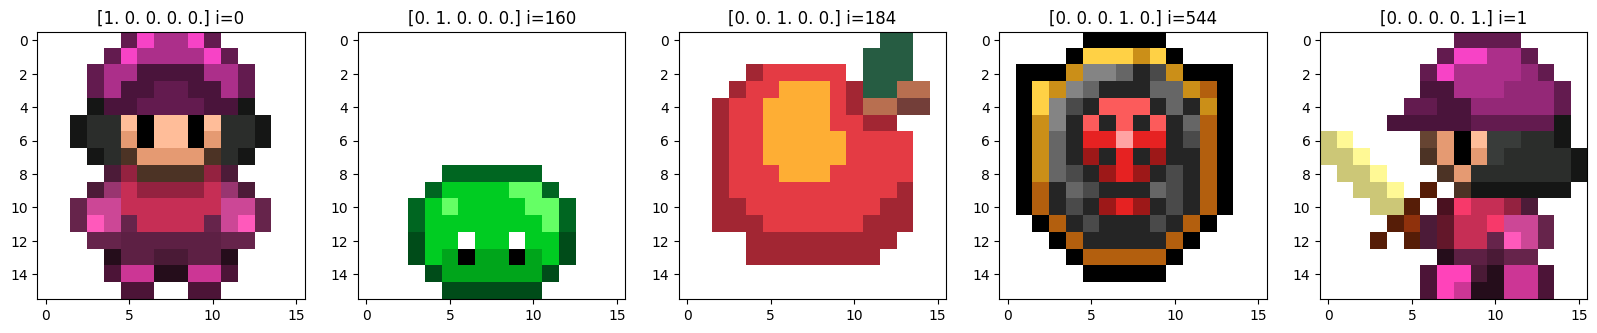

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
indices = [0, 160, 184, 544, 1]
for i in range(5):
    index = indices[i]
    ax[i].imshow(X[index])
    ax[i].set_title(f"{y[index]} i={index}")

By displaying the averages for each label, we can get an idea of common elements for each type:

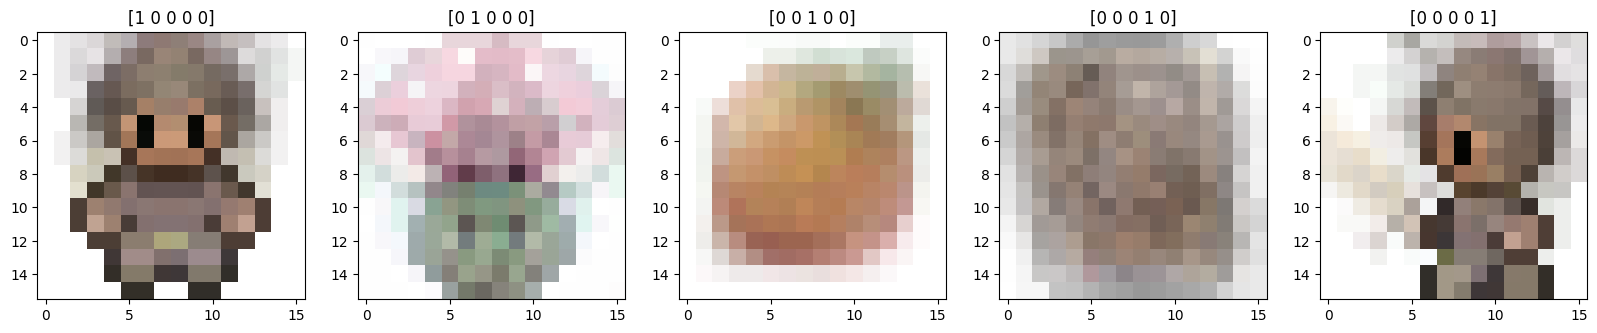

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

labels = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

for i in range(5):
    mask = np.all(y == labels[i], axis=1)
    average = np.sum(X[mask], axis=0) / np.sum(mask)
    average /= 255
    
    ax[i].imshow(average)
    ax[i].set_title(str(labels[i]))

As seen above, the sprites for characters have very strong features that are similar to eachother.

# Building the Model
We decided on using a convolutional neural network because the problem we decided to solve was one of image classification, and a convolutional neural network it adept at processing this kind of task. This is especially the case since recently, convolution layers have led to significant increases in accuracy related to image classification. Additionally, since our dataset contained multiple different classes, so it would make sense to use a classifier which is has flexibility in the process of selecting its parameters.

*A demonstration of what convolution can do to our dataset. Without training, the convolution filters are random.*

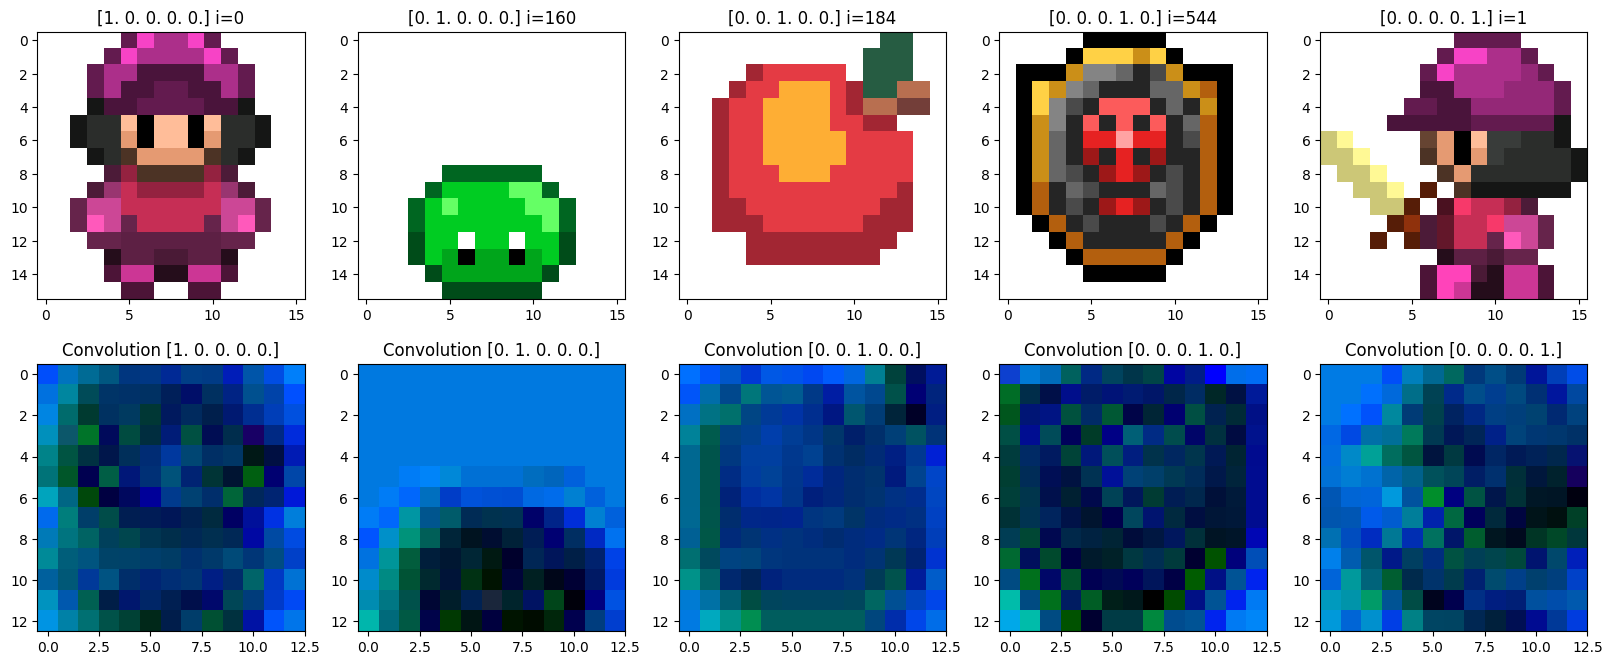

In [6]:
indices = [0, 160, 184, 544, 1]
example_sprites = np.array(X[indices])
keras.utils.set_random_seed(0)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(3, (4, 4), (1, 1), activation='relu', padding='valid'))

fig, ax = plt.subplots(2, 5, figsize=(20, 20))
fig.subplots_adjust(hspace=-0.725)
for i in range(5):
    ax[0, i].imshow(example_sprites[i])
    ax[0, i].set_title(f"{y[indices[i]]} i={indices[i]}")
    conv_result = model(example_sprites[i][np.newaxis, ...] / 255)
    ax[1, i].imshow(conv_result[0] / np.max(conv_result[0]))
    ax[1, i].set_title(f"Convolution {y[indices[i]]}")

We built our model builder function to be thourough with many different approaches to sort out our neural network.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

def create_model(optimizer='adam', kernel=3):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(16, 16, 3)))
    model.add(keras.layers.Conv2D(3, (kernel, kernel), (1, 1), activation='relu', padding='same', name='conv_layer'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(5, activation='softmax'))
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

param_grid = {
    #'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30, 40],
    'batch_size': [40, 60, 80],
    #'epochs': [64, 128, 256],
    'optimizer': ['adam', 'rmsprop'],
    'kernel': [2, 3, 4, 5]
}

model = KerasClassifier(build_fn=create_model, verbose=0, optimizer='adam', kernel=3)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=0)

grid_result = None
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.9748294987129474 using {'batch_size': 80, 'epochs': 40, 'kernel': 5, 'optimizer': 'rmsprop'}


## A little bit of trial and error
Through creating layers for our sequential model, we originally thought that upsampling would help improve our model accuracy with it's ability to identify outlines, however, it would severely misclassify characters(front), monsters, and food.

We also found out that the SGD optimizer often misclassified everything as an item. This is probably due to the fact that there are more items than anything else in the dataset and it would settle on classifying everything as such. Same happened with the adadelta optimizer. Both the adam and rmsprop optimizers seem to perform similarly.

We also saw that when defining the convolution layer, setting the size of the kernel to 2 and 5 yielded similar, yet better results.

In [8]:
grid_result.best_estimator_.model_.summary()

y_pred = grid_result.predict(X_test)
print(f"Test accuracy: {np.mean(y_pred == y_test)}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_layer (Conv2D)             │ (None, 16, 16, 3)      │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,309 (583.24 KB)

 Trainable params: 49,769 (194.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,540 (388.83 KB)

Test accuracy: 0.9865546218487395


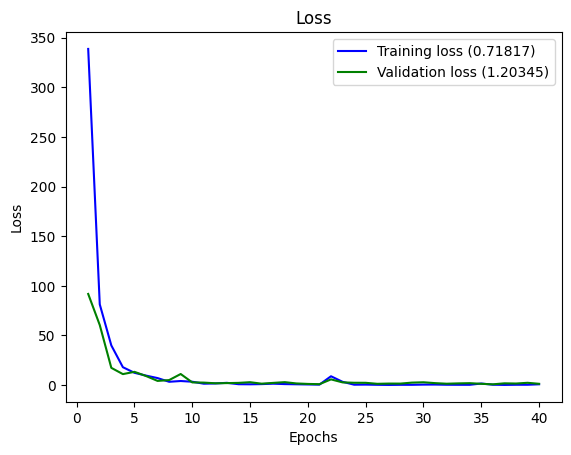

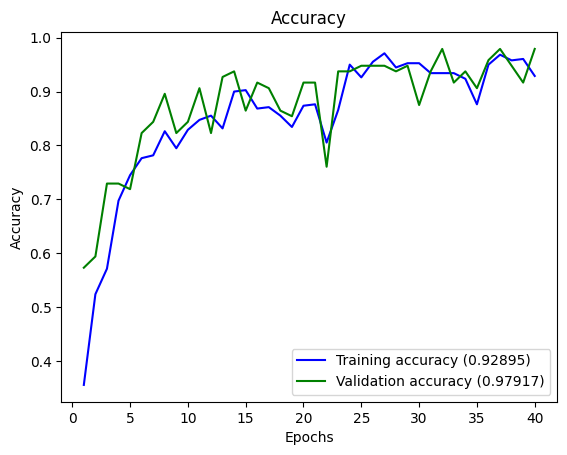

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True, stratify=y_train)

model = None
history = None
with warnings.catch_warnings(action='ignore'):
    model = create_model(optimizer=grid_result.best_params_['optimizer'])
    history = model.fit(X_train, y_train, batch_size=grid_result.best_params_['batch_size'], epochs=grid_result.best_params_['epochs'], validation_data=(X_val, y_val), verbose=0)

plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


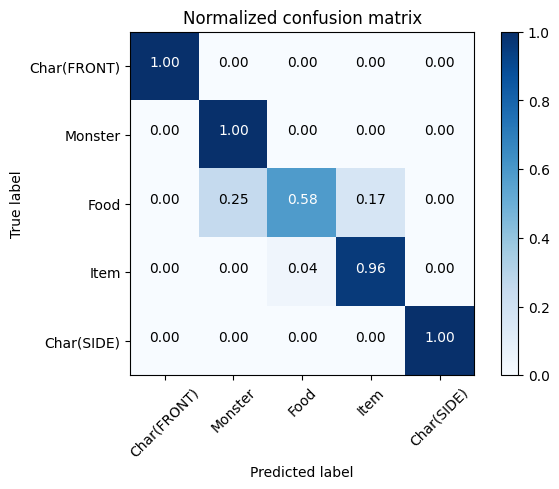

In [10]:
y_pred = model.predict(X_test)
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(matrix, classes=['Char(FRONT)', 'Monster', 'Food', 'Item', 'Char(SIDE)'], normalize=True)

# A Little Demonstration
Here, I've added a widget to play with to see the results of our model. We can even grab the convolution layer from the model to see what information it may be looking at.

In [14]:
label_names = ['Character (FORWARD)', 'Monster', 'Food', 'Item', 'Character (SIDE)']

conv_visual_conv = grid_result.best_estimator_.model_.get_layer('conv_layer')

index_slider = widgets.IntSlider(value=0, min=0, max=len(X)-1, description='Image index:', layout=widgets.Layout(width='80%'))
def show_image(index):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(X[index])
    ax[0].set_title(f"{y[index]} i={index}")
    conv_result = conv_visual_conv(X[index][np.newaxis, ...] / 255)
    ax[1].imshow(conv_result[0] / np.max(conv_result[0]))
    ax[1].set_title(f"Convolution {y[index]}")
    prediction = model(X[index:index+1]).numpy()
    print(f'Predicted label: {np.argmax(prediction)} ({label_names[np.argmax(prediction)]})')
    print(f'Actual label:    {np.argmax(y[index])} ({label_names[np.argmax(y[index])]})')
    print('Predicted probabilities:')
    print(f'    Character (FORWARD): {'%.2f' % (prediction[0][0] * 100)}%')
    print(f'    Monster:             {'%.2f' % (prediction[0][1] * 100)}%')
    print(f'    Food:                {'%.2f' % (prediction[0][2] * 100)}%')
    print(f'    Item:                {'%.2f' % (prediction[0][3] * 100)}%')
    print(f'    Character (SIDE):    {'%.2f' % (prediction[0][4] * 100)}%')
widgets.interactive(show_image, index=index_slider)

interactive(children=(IntSlider(value=0, description='Image index:', layout=Layout(width='80%'), max=594), Out…

# Conclusion & Hindsight
After working through this, the dataset we chose could have been more interesting. This dataset is fairly small, and doesn't have all that much diversity. However, this project has been pretty interesting in terms of being able to observe, learn, and discuss machine learning techniques.

After working with this dataset, we are much more knowledgeable regarding the process of training a neural network. In general, we learned that the visualization of data is can be quite helpful in discerning the discrepancies between the different classes of data and the parameters used to classify them. Because of this, we discovered that it was quite helpful to display the averages of each class. For this dataset specifically, there were very prominent features of certain classes. For example, the far majority of the characters have eyes in the same position, so it should be relatively trivial to tell the difference between a character and an item. 


We encountered a lot of issues with how small the dataset actually is. Through overfitting / underfitting with different hyperparameters, it was difficult to find a model that work well for this dataset.

The main drawbacks of this project are the restrictions of this data set. The sprites themselves aren't all that consistent in style other than within their own labels, and the sizes of all the sprites are 16x16, so there isn't much data to work off of. It can be easy to blend between two classes in this. This can be seen with the errors with food sprites being confused with monster and item sprites. Also, the character sprites all are extremely similar, so it was extpected to be able to be extremely confident in those areas.

# Contributions
Most code was completed through pair programming, and writing was completed by both team members. Here are some bullet points on focus, but each portion of the project had work done by both.
### Erik Cooper
- Visualizations
- Data pre-processing
- Sequential model design
### Chris Beall
- Cross validation
- Testing
- Metric research